In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from skimage.color import rgb2gray

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr
import fig_setup

fig_setup.fig_setup()

/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1554382501.py:31: RuntimeWarning: invalid value encountered in power
  axs[0,0].imshow(rolling_0**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1554382501.py:32: RuntimeWarning: invalid value encountered in power
  axs[0,1].imshow(rolling_90**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1554382501.py:33: RuntimeWarning: invalid value encountered in power
  axs[1,0].imshow(rolling_180**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1554382501.py:34: RuntimeWarning: invalid value encountered in power
  axs[1,1].imshow(rolling_270**(1.0/2.2)*100, cmap='gray')


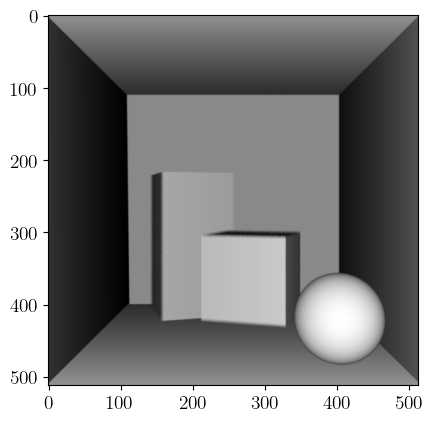

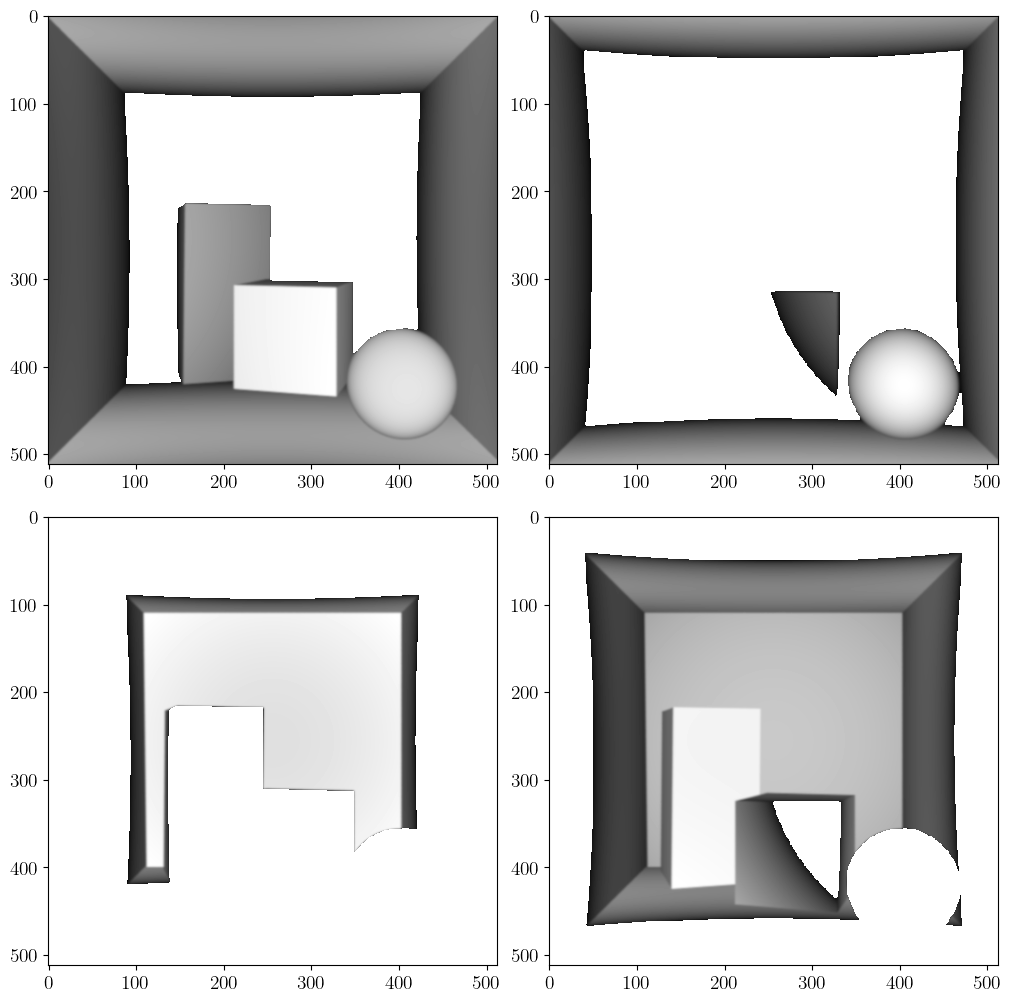

In [2]:
# data paths and variables
save_figs = False

wavelength = 2000 # pathspace units
mod_freq = c / wavelength
k_deg = 90
k = np.deg2rad(k_deg)
uss_dim='1d'
sigma=1
cropY=0
cropX = 0
phase_variation_axis="y"

# Load the global shutter image
global_shutter = rgb2gray(np.load('data/moving_scene/fullframe_500us.npy'))
plt.imshow(global_shutter**(1.0/2.2)*100, cmap='gray')

# Load rolling shutter composite frame
rolling_snapshot = rgb2gray(np.load('data/moving_scene/snapshot_composite.npy'))

# Load the rolling shutter conventional frames
with np.load('data/moving_scene/rolling_shutter_phases.npz') as phase_data:
    rolling_0 = gaussian_filter(phase_data['phase0'][cropY:, cropX:], sigma)
    rolling_90 = gaussian_filter(phase_data['phase90'][cropY:, cropX:], sigma)
    rolling_180 = gaussian_filter(phase_data['phase180'][cropY:, cropX:], sigma)
    rolling_270 = gaussian_filter(phase_data['phase270'][cropY:, cropX:], sigma)

quad_frames = [rolling_0, rolling_90, rolling_180, rolling_270]

fig, axs = plt.subplots(2,2, figsize=(10,10), layout='constrained')
axs[0,0].imshow(rolling_0**(1.0/2.2)*100, cmap='gray')
axs[0,1].imshow(rolling_90**(1.0/2.2)*100, cmap='gray')
axs[1,0].imshow(rolling_180**(1.0/2.2)*100, cmap='gray')
axs[1,1].imshow(rolling_270**(1.0/2.2)*100, cmap='gray')

### Create a rolling shutter snapshot simulation

In [3]:
# create a simulation
rolling_sp_sim = fft_shift.FFT_Shift(k,
                                     global_shutter, global_shutter,
                                     omega = 2.0 * pi * (mod_freq * 1e6))

# load rolling shutter composite intensity
rolling_sp_sim.create_composite_intensity_snapshot(rolling_snapshot)

# calculate the fft shift
rolling_sp_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_sp = rolling_sp_sim.reconstruct_intensity()
recon_phase_sp = -rolling_sp_sim.reconstruct_phase()


### Create a rolling shutter conventional simulation

In [4]:
# create a simulation
rolling_conv_sim = sim.Simulation(global_shutter, global_shutter,
                                  omega = 2.0 * pi * (mod_freq * 1e6))

# load rolling shutter composite intensity
rolling_conv_sim.create_quad_intensity_from_data(quad_frames)

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_conv = rolling_conv_sim.compute_amplitude_conventional()
recon_phase_conv = rolling_conv_sim.compute_phase_conventional()

### Create global shutter conventional sim

/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1829465215.py:15: RuntimeWarning: invalid value encountered in power
  axs[0,0].imshow(global_0**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1829465215.py:16: RuntimeWarning: invalid value encountered in power
  axs[0,1].imshow(global_90**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1829465215.py:17: RuntimeWarning: invalid value encountered in power
  axs[1,0].imshow(global_180**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/1829465215.py:18: RuntimeWarning: invalid value encountered in power
  axs[1,1].imshow(global_270**(1.0/2.2)*100, cmap='gray')


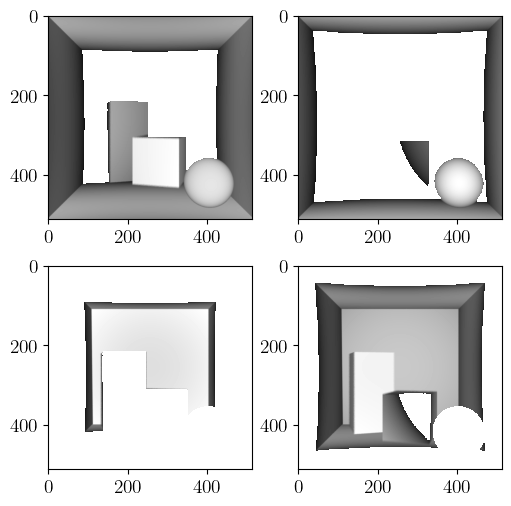

In [5]:
with np.load('data/moving_scene/global_shutter_conventional_phases.npz') as phase_data:
    global_0 = phase_data['phase0'][cropY:, cropX:]
    global_90 = phase_data['phase90'][cropY:, cropX:]
    global_180 = phase_data['phase180'][cropY:, cropX:]
    global_270 = phase_data['phase270'][cropY:, cropX:]

global_conv_sim = sim.Simulation(global_shutter, global_shutter,
                                 omega = 2 * pi * (mod_freq * 1e6))

global_conv_sim.create_quad_intensity_from_data([global_0, global_90, global_180, global_270])
global_intensity = global_conv_sim.compute_amplitude_conventional()
global_phase = global_conv_sim.compute_phase_conventional()

fig_global, axs = plt.subplots(2,2, figsize=(5,5), layout='constrained')
axs[0,0].imshow(global_0**(1.0/2.2)*100, cmap='gray')
axs[0,1].imshow(global_90**(1.0/2.2)*100, cmap='gray')
axs[1,0].imshow(global_180**(1.0/2.2)*100, cmap='gray')
axs[1,1].imshow(global_270**(1.0/2.2)*100, cmap='gray')

### Create ground truth sim

Note: the ground truth is actually just a global shutter image taken with a 500 us exposure duration starting at time 0.002, where all 4 phases are taken simultaneously

/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/3256916010.py:15: RuntimeWarning: invalid value encountered in power
  axs[0,0].imshow(gt_0**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/3256916010.py:16: RuntimeWarning: invalid value encountered in power
  axs[0,1].imshow(gt_90**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/3256916010.py:17: RuntimeWarning: invalid value encountered in power
  axs[1,0].imshow(gt_180**(1.0/2.2)*100, cmap='gray')
/var/folders/nv/5s8q36hx2w7_5421979k__f80000gn/T/ipykernel_99415/3256916010.py:18: RuntimeWarning: invalid value encountered in power
  axs[1,1].imshow(gt_270**(1.0/2.2)*100, cmap='gray')


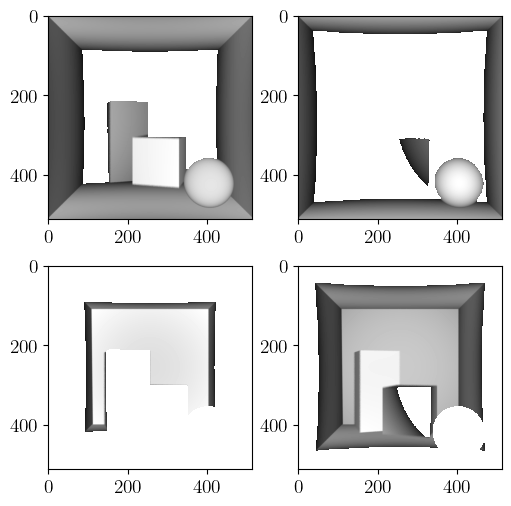

In [6]:
with np.load('data/moving_scene/global_shutter_first_frame_phases.npz') as phase_data:
    gt_0 = phase_data['phase0'][cropY:, cropX:]
    gt_90 = phase_data['phase90'][cropY:, cropX:]
    gt_180 = phase_data['phase180'][cropY:, cropX:]
    gt_270 = phase_data['phase270'][cropY:, cropX:]

gt_sim = sim.Simulation(global_shutter, global_shutter,
                        omega = 2.0 * pi * (mod_freq * 1e6))

gt_sim.create_quad_intensity_from_data([gt_0, gt_90, gt_180, gt_270])
gt_intensity = gt_sim.compute_amplitude_conventional()
gt_phase = gt_sim.compute_phase_conventional()

fig_gt, axs = plt.subplots(2,2, figsize=(5,5), layout='constrained')
axs[0,0].imshow(gt_0**(1.0/2.2)*100, cmap='gray')
axs[0,1].imshow(gt_90**(1.0/2.2)*100, cmap='gray')
axs[1,0].imshow(gt_180**(1.0/2.2)*100, cmap='gray')
axs[1,1].imshow(gt_270**(1.0/2.2)*100, cmap='gray')

### Calculate SNR and visualize

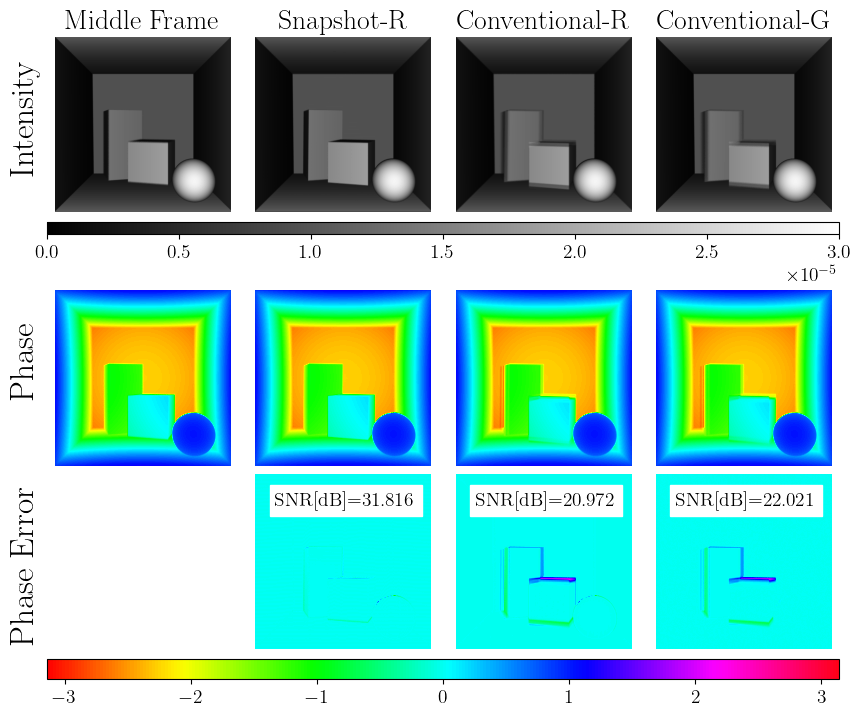

In [7]:
snr_sp = calculate_snr(gt_phase, recon_phase_sp)
snr_conv = calculate_snr(gt_phase, recon_phase_conv)
snr_conv_global = calculate_snr(gt_phase, global_phase)

fig_recon, axs_recons = plt.subplots(3,4, layout='constrained', figsize=(8.25, 7))

# plot the reconstructions
axs_recons[0,0].set_title("Middle Frame")
axs_recons[0,0].axis("off")
img = axs_recons[0,0].imshow(gt_intensity, cmap="gray", vmin=0, vmax=3e-5)
fig_recon.colorbar(img, ax=axs_recons[0,:], orientation='horizontal', fraction=0.07, aspect=65)
fig_recon.text(-0.025,0.77, 'Intensity', rotation='vertical')

axs_recons[0,1].set_title("Snapshot-R")
axs_recons[0,1].axis("off")
axs_recons[0,1].imshow(recon_intensity_sp, cmap="gray", vmin=0, vmax=3e-5)

axs_recons[0,2].set_title("Conventional-R")
axs_recons[0,2].axis("off")
axs_recons[0,2].imshow(recon_intensity_conv, cmap="gray", vmin=0, vmax=3e-5)

axs_recons[0,3].set_title("Conventional-G")
axs_recons[0,3].axis("off")
axs_recons[0,3].imshow(global_intensity, cmap="gray", vmin=0, vmax=3e-5)

fig_recon.text(-0.025,0.45, 'Phase', rotation='vertical')
axs_recons[1,0].axis("off")
axs_recons[1,0].imshow(gt_phase, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[1,1].axis("off")
axs_recons[1,1].imshow(recon_phase_sp, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[1,2].axis("off")
axs_recons[1,2].imshow(recon_phase_conv, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[1,3].axis("off")
axs_recons[1,3].imshow(global_phase, cmap="hsv", vmin=-pi, vmax=pi)

# plot the snr
fig_recon.text(-0.025,0.1, 'Phase Error', rotation='vertical')
axs_recons[2,0].axis('off')

axs_recons[2,1].axis("off")
axs_recons[2,1].annotate("SNR[dB]={:.3f}".format(snr_sp), (58,90), fontsize=14, backgroundcolor='w')
img = axs_recons[2,1].imshow(gt_phase - recon_phase_sp, cmap='hsv', vmin=-pi, vmax=pi)
fig_recon.colorbar(img, ax=axs_recons[2:], orientation='horizontal', fraction=0.15, aspect=40)

axs_recons[2,2].annotate("SNR[dB]={:.3f}".format(snr_conv), (58,90), fontsize=14, backgroundcolor='w')
axs_recons[2,2].axis("off")
axs_recons[2,2].imshow(gt_phase - recon_phase_conv, cmap='hsv', vmin=-pi, vmax=pi)

axs_recons[2,3].annotate("SNR[dB]={:.3f}".format(snr_conv_global), (58,90), fontsize=14, backgroundcolor='w')
axs_recons[2,3].axis("off")
axs_recons[2,3].imshow(gt_phase - global_phase, cmap='hsv', vmin=-pi, vmax=pi)

plt.show()

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/moving_scene.pdf", bbox_inches = 'tight')

#### Vertical version of the same figure

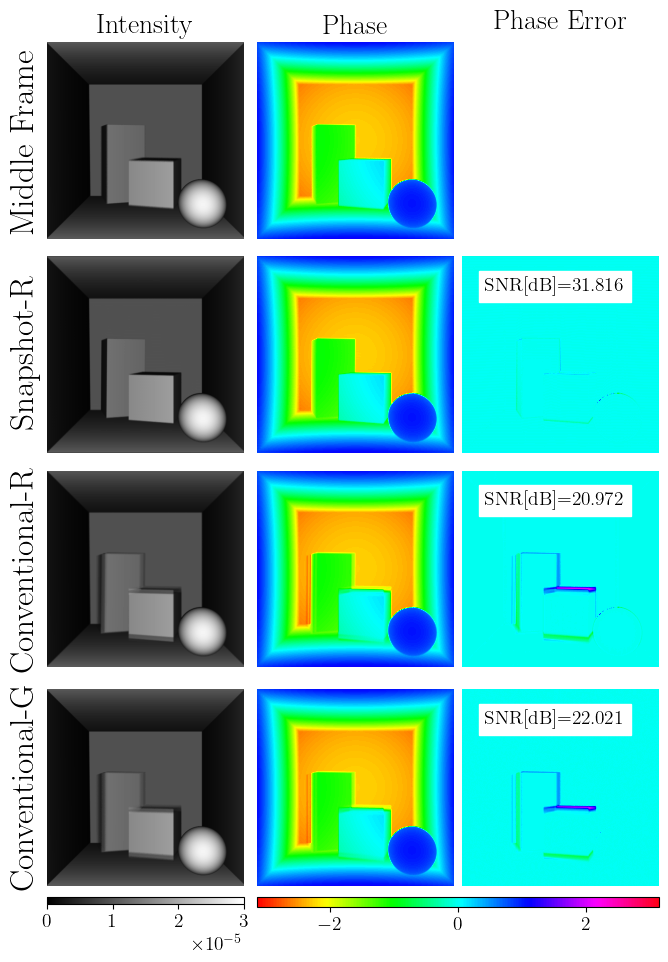

In [8]:
fig_recon, axs_recons = plt.subplots(4,3, layout='constrained', figsize=(6.25, 9.5))

# plot the reconstructions
axs_recons[0,0].set_title("Intensity")
axs_recons[0,0].axis("off")
axs_recons[0,0].imshow(gt_intensity, cmap="gray", vmin=0, vmax=3e-5)
fig_recon.text(-0.045,0.766, 'Middle Frame', rotation='vertical')

fig_recon.text(-0.045,0.56, 'Snapshot-R', rotation='vertical')
axs_recons[1,0].axis("off")
axs_recons[1,0].imshow(recon_intensity_sp, cmap="gray", vmin=0, vmax=3e-5)

fig_recon.text(-0.045,0.305, 'Conventional-R', rotation='vertical')
axs_recons[2,0].axis("off")
axs_recons[2,0].imshow(recon_intensity_conv, cmap="gray", vmin=0, vmax=3e-5)

fig_recon.text(-0.045,0.075, 'Conventional-G', rotation='vertical')
axs_recons[3,0].axis("off")
img = axs_recons[3,0].imshow(global_intensity, cmap="gray", vmin=0, vmax=3e-5)
fig_recon.colorbar(img, ax=axs_recons[3,0], orientation='horizontal', aspect=30)

axs_recons[0,1].set_title('Phase')
axs_recons[0,1].axis("off")
axs_recons[0,1].imshow(gt_phase, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[1,1].axis("off")
axs_recons[1,1].imshow(recon_phase_sp, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[2,1].axis("off")
axs_recons[2,1].imshow(recon_phase_conv, cmap="hsv", vmin=-pi, vmax=pi)

axs_recons[3,1].axis("off")
axs_recons[3,1].imshow(global_phase, cmap="hsv", vmin=-pi, vmax=pi)

# plot the snr
axs_recons[0,2].set_title('Phase Error')
# fig_recon.text(-0.025,0.1, 'Phase Error', rotation='vertical')
axs_recons[0,2].axis('off')

axs_recons[1,2].axis("off")
axs_recons[1,2].annotate("SNR[dB]={:.3f}".format(snr_sp), (58,90), fontsize=14, backgroundcolor='w')
img = axs_recons[1,2].imshow(gt_phase - recon_phase_sp, cmap='hsv', vmin=-pi, vmax=pi)

axs_recons[2,2].annotate("SNR[dB]={:.3f}".format(snr_conv), (58,90), fontsize=14, backgroundcolor='w')
axs_recons[2,2].axis("off")
axs_recons[2,2].imshow(gt_phase - recon_phase_conv, cmap='hsv', vmin=-pi, vmax=pi)

axs_recons[3,2].annotate("SNR[dB]={:.3f}".format(snr_conv_global), (58,90), fontsize=14, backgroundcolor='w')
axs_recons[3,2].axis("off")
axs_recons[3,2].imshow(gt_phase - global_phase, cmap='hsv', vmin=-pi, vmax=pi)
fig_recon.colorbar(img, ax=axs_recons[3,1:], orientation='horizontal', fraction=0.15, aspect=40)


plt.show()

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/moving_scene_vert.pdf", bbox_inches = 'tight')

### Visualize the snapshot fft

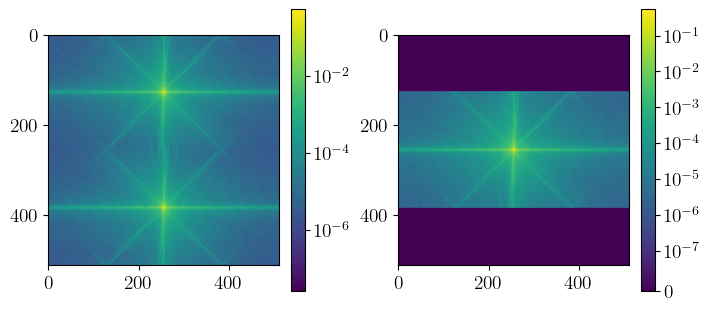

In [9]:
fig_fft, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
fft_rolling = rolling_sp_sim.fft
fft_rolling_centered = rolling_sp_sim.fft_centered

im = ax[0].imshow(np.abs(fft_rolling), norm=LogNorm())
fig_fft.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.abs(fft_rolling_centered), norm=SymLogNorm(linthresh=1e-7))
fig_fft.colorbar(im, ax=ax[1])